<a href="https://colab.research.google.com/github/thalankiabhishek/mlImage/blob/master/CNN_Was_that_a_horse_or_a_person.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Training Set: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip

Val Set: https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip

In [39]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip -qq
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip -qq 
!mkdir CNN; mkdir CNN/train CNN/test
!unzip -qq horse-or-human.zip -d CNN/train
!unzip -qq validation-horse-or-human.zip -d CNN/test; rm -rf *.zip

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import PIL, cv2
import os

from tqdm.notebook import tqdm

from google.colab.patches import cv2_imshow

In [41]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.models import Sequential
from keras.layers import Dense

In [42]:
horses = []
humans = []

for data in os.listdir('/content/CNN'):
  for folder in os.listdir(os.path.join('/content/CNN', data)):
    if folder == 'horses':
      for img in tqdm(os.listdir(os.path.join('/content/CNN', data, folder))):
        image = cv2.imread(os.path.join('/content/CNN', data, folder, img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        horses.append(image)

    elif folder == 'humans':
      for img in tqdm(os.listdir(os.path.join('/content/CNN', data, folder))):
        image = cv2.imread(os.path.join('/content/CNN', data, folder, img))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        humans.append(image)

    else:
      continue

In [43]:
x = np.concatenate((horses, humans), 0)
print(x.shape[0], "images have", x.shape[1], "x", x.shape[2], "pixels.")

# We create our classify data. 1 for human and 0 for horses. 
y = np.concatenate((np.zeros(len(horses)), np.ones(len(humans))), axis= 0).reshape(-1,1)

1283 images have 300 x 300 pixels.


In [44]:
x_flatten = x.reshape(x.shape[0], x.shape[1], x.shape[2], -1)

In [45]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_flatten, y, test_size = 0.3, random_state = 42)

In [46]:
# Part 2 - Fitting the CNN to the images
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow(x=x_train, y= y_train, batch_size=10, shuffle=True, seed=73)#, save_to_dir='/content/CNN', save_prefix='train_')


test_datagen = ImageDataGenerator(rescale = 1./255)
test_set = test_datagen.flow(x=x_test, y= y_test, batch_size=10, shuffle=True, seed=73)#, save_to_dir='/content/CNN', save_prefix='test_')


In [47]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [48]:
# Initialising the CNN
classifier = Sequential()

classifier.add(Conv2D(32, (3, 3), input_shape = next(training_set)[0].shape[1:], activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(16, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(8, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Conv2D(4, (3, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Flatten())
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 64, activation = 'relu'))
classifier.add(Dense(units = 32, activation = 'relu'))
classifier.add(Dense(units = 16, activation = 'relu'))
classifier.add(Dense(units = 8, activation = 'relu'))
classifier.add(Dense(units = 4, activation = 'relu'))
classifier.add(Dense(units = 1, activation = 'sigmoid'))

classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 147, 16)      4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 71, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 35, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 33, 4)        

In [49]:
from keras.callbacks import TensorBoard

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=1,
                          write_graph=False, write_images=True)

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

In [50]:
classifier.fit_generator(generator = training_set,
                         epochs = 25,
                         steps_per_epoch = 10,
                         validation_data = test_set,
                         validation_steps = 5,
                         callbacks = [tensorboard])

Epoch 1/25
10/10 [==============================] - 1s 107ms/step - loss: 0.6924 - accuracy: 0.5400 - val_loss: 0.6956 - val_accuracy: 0.4600
Epoch 2/25
10/10 [==============================] - 1s 82ms/step - loss: 0.6925 - accuracy: 0.5500 - val_loss: 0.6979 - val_accuracy: 0.4200
Epoch 3/25
10/10 [==============================] - 1s 86ms/step - loss: 0.6945 - accuracy: 0.4900 - val_loss: 0.6928 - val_accuracy: 0.5000
Epoch 4/25
10/10 [==============================] - 1s 86ms/step - loss: 0.6940 - accuracy: 0.4800 - val_loss: 0.6919 - val_accuracy: 0.4800
Epoch 5/25
10/10 [==============================] - 1s 85ms/step - loss: 0.6872 - accuracy: 0.5800 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 6/25
10/10 [==============================] - 1s 90ms/step - loss: 0.6699 - accuracy: 0.6000 - val_loss: 0.6022 - val_accuracy: 0.6400
Epoch 7/25
10/10 [==============================] - 1s 86ms/step - loss: 0.6529 - accuracy: 0.5900 - val_loss: 0.6733 - val_accuracy: 0.4400
Epoch 8/25
1

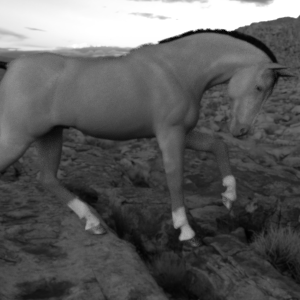

It's a Horsie!


In [54]:
i = np.random.randint(0, high=len(x))
image = x[i]
image = image.reshape(1, image.shape[0], image.shape[1], -1)
# image = np.expand_dims(image, axis=-1)
cv2_imshow(x[i])
img_pred = classifier.predict(image)

if int(img_pred[0][0]) == 0:
  print("It's a Horsie!")
else:
  print("Mouth-Breather")